# Timeline Analysis
Scope of the following analysis is to investigate whether the previously analyzed hashtags actually play a significant role in the underlying network structure: does a specific topic (hashtag) strengthen ties or increases diversity within Twitter users? The idea is therefore to build a metric and extract this information by combining mutual interactions Tweets and the network structure that represented the sole core of the analysis so far.

In [1]:
import snap
from snap import TUNGraph
import os
import sys
import operator
import pandas as pd
import subprocess
import numpy as np
import csv
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
from __future__ import print_function
from IPython.display import HTML, display
import tabulate
import json
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from collections import Counter
import re
from itertools import combinations

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "8.TimelineAnalysis")
tweets_path = "../lib/GetOldTweets-python/out/completed"

## 0. Creation of Model Classes
First of all, I might need to be a bit more concerned about performance since some Tweets files are pretty big (a few GBs), therefore I'd like to optimize some operations as much as possible.
- Since Tweets come naturally with a unique ID, I may create a `Tweet` custom type;
- Class `Interaction` representing an interaction between 2 users.

In [2]:
class Tweet:
    def __init__(self, tweet_id, users, tweet_dict):
        self.tweet_id = tweet_id
        self.tweet_dict = tweet_dict
        self.users = users
        
    def __eq__(self, other):
        if isinstance(other, Tweet):
            return self.tweet_id == other.tweet_id
        return NotImplemented
    
    def __ne__(self, other):
        x = self.__eq__(other)
        if x is not NotImplemented:
            return not x
        return NotImplemented
    
    def __hash__(self):
        return hash(self.tweet_id)

In [3]:
class Interaction:        
    def __init__(self, source, target, periods=None):
        self.source = source
        self.target = target
        self.periods = periods
        
    def __eq__(self, other):
        if isinstance(other, Interaction):
            return (self.source == other.source and self.target == other.target) or (self.source == other.target and self.target == other.source)
        return NotImplemented
    
    def __ne__(self, other):
        x = self.__eq__(other)
        if x is not NotImplemented:
            return not x
        return NotImplemented
    
    def __hash__(self):
        return hash(hash(self.source)+hash(self.target))

Hereby a collection of some utility functions:

In [4]:
def get_relative_percentage(n,m):
    return n*100.0/m

def load_graph_from_backup(filename):
    FIn = snap.TFIn("../data/"+filename+".bin")
    graph = snap.TUNGraph.Load(FIn)
    return graph

def read_large_file(file_object):
    while True:
        data = file_object.readline()
        if not data:
            break
        yield data.rstrip('\n')
        
def process_edge_line(line):
    source, target, prop = line.split(',')
    return int(source), int(target), [int(p) for p in prop.split(';')]
        
def get_usernames_from_basic_tweet_info(hashtag, tweet):
    usernames = set()
    # (1): Has tweeted using hashtag
    if hashtag in [h.lower() for h in tweet["entities"]["hashtags"]]:
        usernames.add(tweet["user"]["screen_name"].lower())

    # (2): Has been mentioned / replied to
    if not tweet["in_reply_to_screen_name"] is None:
        usernames.add(tweet["in_reply_to_screen_name"].lower())
    for mentions in tweet["entities"]["user_mentions"]:
        usernames.add(mentions["screen_name"].lower())
    return usernames

def get_tweet_usernames(hashtag, tweet):
    usernames = set()
    usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet))
    if "retweeted_status" in tweet:
        usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["retweeted_status"]))
    if "quoted_status" in tweet:
        usernames.update(get_usernames_from_basic_tweet_info(hashtag, tweet["quoted_status"]))
    return usernames

def extract_hashtag_usernames(hashtag, tweets):
    hashtag_usernames = set()
    for tweet in tweets:
        hashtag_usernames.update(tweet.users)
    print("Total unique usernames involved in '#%s' hashtag conversations from %d tweets: %d" %(hashtag, len(tweets), len(hashtag_usernames)))
    return hashtag_usernames

# Extract tweets given a specific hashtag
def get_tweets(hashtag):
    tweets_filename = os.path.join(tweets_path,"tweets_#" + hashtag + "_2013-09-01_2016-12-31.json")
    tweets = set()
    with open(tweets_filename) as fin:
        for line in read_large_file(fin):
            tweet_dict = json.loads(line)
            tweet_id = np.int64(tweet_dict["id_str"])
            tweet_users = get_tweet_usernames(hashtag, tweet_dict)
            tweets.add(Tweet(tweet_id, tweet_users, tweet_dict))
    print("Imported %d tweets from %s" %(len(tweets),tweets_filename))
    return tweets

## 1. Extract Tweets: filter usernames and tweets

In [5]:
hashtag = "makeamericagreatagain"
hashtag_full = "#MAGA"

Load hashtag subgraph from backup:

In [6]:
hashtag_subgraph = load_graph_from_backup("mmr_subgraph_"+hashtag)

In [7]:
%%time
tweets = get_tweets(hashtag)

Imported 1498400 tweets from ../lib/GetOldTweets-python/out/completed/tweets_#makeamericagreatagain_2013-09-01_2016-12-31.json
CPU times: user 1min 23s, sys: 4.61 s, total: 1min 28s
Wall time: 1min 28s


In [8]:
hashtag_usernames = extract_hashtag_usernames(hashtag, tweets)

Total unique usernames involved in '#makeamericagreatagain' hashtag conversations from 1498400 tweets: 346194


In [9]:
%%time
usernames_to_id_dict = {}
with open("../data/usernames.csv") as usernames_f:
    for line in read_large_file(usernames_f):
        username = line.split(',')[0]
        encoding = int(line.split(',')[1])
        # Add to dict only if username is part of the hashtag subgraph
        if hashtag_subgraph.IsNode(encoding):
            usernames_to_id_dict[username] = encoding

CPU times: user 2min 49s, sys: 648 ms, total: 2min 50s
Wall time: 2min 50s


The next step is then to filter out those Tweets whose involved users are not part of the corresponding $H$ subgraph (i.e. if none of its involved users represents a node in $H$). The keys of the `usernames_to_id_dict` dictionary correspond to all the usernames of the $H$ subgraph, so it should be sufficient to check the following criteria:
- A tweet is kept if any of its involved users is part of the $H$ subgraph:

In [10]:
tweets_filtered = filter(lambda t: any(map(lambda u: u in usernames_to_id_dict, t.users)), tweets)
print("Number of filtered tweets (with at least 1 involved user within MMR graph data): %d (%.2f%% of %d total tweets)" %(len(tweets_filtered), get_relative_percentage(len(tweets_filtered), len(tweets)), len(tweets)))

Number of filtered tweets (with at least 1 involved user within MMR graph data): 1192392 (79.58% of 1498400 total tweets)


According to the above: among 1.498.400 total tweets, **1.192.392** involve at least one user that is part of the MMR graph data.

In [11]:
def count_tot_users(tweets):
    tot_users = set()
    for t in tweets:
        tot_users.update(t.users)
    return len(tot_users)

tot_users = count_tot_users(tweets_filtered)
print("Total number of unique users involved in %d filtered tweets: %d (%.2f%% of %d total usernames)" %(len(tweets_filtered), tot_users, get_relative_percentage(tot_users, len(hashtag_usernames)), len(hashtag_usernames)))

Total number of unique users involved in 1192392 filtered tweets: 279568 (80.75% of 346194 total usernames)


**Note**: Of course the number of users involved in the filtered tweets may be higher than the actual number of nodes in $H$, since each Tweet might include users that have not been captured by the MMR data. The reason why I decided to apply this filtering step, is that the users collected by the MMR graph data hide some extra interaction properties, e.g. 2 users are related if their total number of interactions within a 3 months period is sufficiently high, so that it represents a constant interaction over time and not a random one. This way we would already remove a lot of noisy/irrelevant data and speed up the algorithms in the next steps.

Hereby a summary of the filtering steps and the statistics about the collected tweets and usernames:

| Property | Before Filtering | After Filtering | % After/Before
|---|---|---|---|
| **Total Collected Tweets** | 1.498.400 | 1.192.392 | 79,58%
| **Total Unique Usernames** | 346.194 | 279.568 | 80,75%

## 2. User Interactions Statistics
I could first show some statistics about the interactions.

### 2.1 Top Interactions
I may show which are the interactions that occurred the most throughout the years we're considering. It's convenient to create a dictionary with $K \rightarrow V$ pairs where $K$ = interaction, $V$ = count (count how many times two people have interacted with each other within the whole timeline period we're considering).

Collecting the interactions count dictionary may be done linearly with a single pass, and the steps are hereby summarized:
1. For each tweet, create a list of all possible pairs of its involved users and for each of them create an `Interaction` instance;
2. Add a new entry to the dictionary with value 1, if the interaction is not existing;
3. If the interaction is already existing, increment its value. 

In [12]:
def create_interactions_count_dict(tweets):
    interactions_count = {}
    for t in tweets:
        pairs = list(combinations(t.users, 2))
        for p in pairs:
            i = Interaction(p[0], p[1])
            if i in interactions_count:
                interactions_count[i] += 1
            else:
                interactions_count[i] = 1
    return interactions_count

In [13]:
interactions_count = create_interactions_count_dict(tweets_filtered)

Let's visualize the results conveniently through a DataFrame, by first sorting it with descending counts (I only show the top interactions e.g. whose count value are at least 100):

In [14]:
interactions_df = pd.DataFrame(data=[(el[0].source, el[0].target, el[1]) for el in interactions_count.items()], columns=["Source", "Target", "Count"])

In [15]:
interactions_df.sort_values(by="Count", ascending=False, inplace=True)
interactions_df[interactions_df["Count"]>=100]

,Source,Target,Count
319136,danscavino,realdonaldtrump,16937
119519,foxnews,realdonaldtrump,12841
744096,hillaryclinton,realdonaldtrump,11425
752093,realdonaldtrump,tedcruz,8585
62617,ilduce2016,realdonaldtrump,7234
314171,cnn,realdonaldtrump,7197
1948,globalsocialm2,realdonaldtrump,6264
402991,gop,realdonaldtrump,5730
429765,erictrump,realdonaldtrump,5101
467220,seanhannity,realdonaldtrump,4959


The above DataFrame therefore shows who are the pairs of users that interacted the most on a time basis about hashtag **#MakeAmericaGreatAgain**. Please remind that because of the filtering performed in the previous section, DataFrame might include some users that are not part of the graph data.

Another perspective may be given instead to highlight which individual users have been involved in the highest number of interactions:

In [16]:
temp1 = interactions_df.groupby(['Source']).sum().reset_index().rename(columns={'Source':'User'})
temp2 = interactions_df.groupby(['Target']).sum().reset_index().rename(columns={'Target':'User'})
temp = temp1.append(temp2)
temp = temp.groupby(['User']).sum().reset_index()
temp.sort_values(by="Count",ascending=False, inplace=True)
temp[temp["Count"]>=500]

,User,Count
170806,realdonaldtrump,758215
73224,foxnews,71249
51759,danscavino,66905
86242,hillaryclinton,58393
43898,cnn,46671
201162,tedcruz,45448
79782,gop,31977
185091,seanhannity,26622
67933,erictrump,24374
59825,donaldjtrumpjr,20553


The result above gives an idea about who have been the most active users around the hashtag topic overtime.

In [31]:
# Backup DataFrames to visualize top interactions with NetworkX / Graphistry
interactions_df[interactions_df["Count"]>=50].to_csv(os.path.join(data_dir, "graph_visualization_top_interactions/"+hashtag+"_top_interactions.csv"),index=False)
temp[temp["Count"]>=100].to_csv(os.path.join(data_dir, "graph_visualization_top_interactions/"+hashtag+"_users_frequency.csv"),index=False)

In [16]:
# Include only interactions that are captured by MMR data
interactions_df = interactions_df[interactions_df.apply(lambda x: x["Source"] in usernames_to_id_dict and x["Target"] in usernames_to_id_dict, axis=1)]
src_encodings = interactions_df.apply(lambda x: usernames_to_id_dict[x["Source"]], axis=1)
trg_encodings = interactions_df.apply(lambda x: usernames_to_id_dict[x["Target"]], axis=1)
interactions_df["Source_ID"] = src_encodings
interactions_df["Target_ID"] = trg_encodings

In [17]:
interactions_df.head()

,Source,Target,Count,Source_ID,Target_ID
319136,danscavino,realdonaldtrump,16937,13036082,3793089
119519,foxnews,realdonaldtrump,12841,5757618,3793089
744096,hillaryclinton,realdonaldtrump,11425,31812949,3793089
752093,realdonaldtrump,tedcruz,8585,3793089,23070713
314171,cnn,realdonaldtrump,7197,373087,3793089


## 3. Measuring interactions consistency overtime
What I'm now interested in, and what actually represents the end goal of this whole work, is identifying a measure of consistency related to the interactions of people taking part of controversies on Twitter. According to the data I am provided with, I may identify 2 paths:
- **MMR graph data**: there's a property of the graph data that hasn't been used so far but still lies in the CSV files I got as result of all the data transformation steps that featured the first notebooks. This property would already give a built-in definition of *interaction consistency*; however, the information we may infer from it is quite limited, and the reason is that for each pair of users we only know whether they have interacted (consistently) within a 3 months period, and given the ranges of our timeline this sums up to a total of 13 periods. It's the only way, however, to compare how interaction consistency has changed overtime;
- **Tweets**: when limiting the scope to the tweets related to a specific topic (hashtag), I have no information about which other topics all involved users have been tweeting about neither the related temporal information. Therefore, I may only know when has the *first* Twitter interaction occurred between each pair of mutually interacting users and all the subsequent ones. This is something that has already been highlighted a bit with the previous section, however I may further narrow it down and measure interactions consistency overtime if I count the interactions *per month*.

### 3.1 Long-term interaction consistency comparison: Analyzing behavioral changes overtime
The idea of this analysis is to compare interaction consistency before and after the first $H$-type interaction, in order to highlight the bonding effect of a given hashtag: does it actually strengthen or weaken ties overtime? Are users more or less likely to communicate with each other after their $H$ interaction? We want to address these questions by carrying out this first timeline analysis by using metadata as edge attributes provided by the MMR graph data.

In details: we have a total of 13 periods, ranging from 2013-09 to 2016-12, each of 3 months duration. For each edge in $H$ and for each of the periods, we then have a binary variable with values 1/0, set to 1 if the interaction occurred in the respective 3 months period, 0 otherwise (simplification of True/False values). Let's say, given period with 0-based index $i$ and edge $e$: $IsInPeriod(e,i)$ is a function as defined below:

$$
IsInPeriod(e,i) =
    \begin{cases}
        1 & \text{if $e$ occurred in period $i$,}\\
        0 & \text{otherwise.}
    \end{cases}
$$

Then, the **mutual interaction consistency** of edge $e$, calculated over $P$ consecutive periods starting from period with index $k$ until period with index $j$ (with $j +1 \ge k$), is given by:

$$MIC(e,k,j) = \frac{\sum_{i=k}^{j}IsInPeriod(e,i)}{P} = \frac{\sum_{i=k}^{j}IsInPeriod(e,i)}{j-k+1}$$

Based on the values of $j$ and $k$, $MIC$ becomes meaningful if we consider its **average** over all edges. Therefore, the **average mutual interaction consistency** $\langle MIC \rangle$ may be calculated in three similar ways:
- $\langle MIC \rangle_{T}$: for each edge $e$, $P = 13$, $k=0$, $j=12$ (the whole timeline period);
- $\langle MIC \rangle_{B}$: for each edge $e$, $P$ is the number of consecutive periods *before* the first $H$ interaction between nodes of edge $e$, i.e. if the first interaction occurred in period with index $q$, then $k=0$, $j=q-1$;
- $\langle MIC \rangle_{A}$: for each edge $e$, $P$ is the number of consecutive periods *after* the first $H$ interaction between nodes of edge $e$, i.e. $k=q$, $j=12$.

In general, given $E$ as the set of edges of $H$ subgraph:

$$\langle MIC \rangle = \frac{\sum_{e \in E}MIC(e)}{|E|}$$

where the values of $k$ and $j$, that depend directly on the considered edge $e$ based on which type of $\langle MIC \rangle$ we're calculating, have been encapsulated inside the $MIC$ function.

Values of $\langle MIC \rangle_{T}$ may then be compared across different $H$ subgraphs, whereas $\langle MIC \rangle_{B}$ and $\langle MIC \rangle_{A}$ may be then directly compared within the same $H$ subgraph to quantify the bonding impact of hashtag $H$ overtime.

As a first step, we need to conveniently store the edges attribute. This metadata is already transformed into an array of integers where values are the encoding of the periods, ranging from 0 to 12, where period $0$ is period between 2013-09 and 2013-11 (edges included),  and period $12$ between 2016-09 and 2016-11.

I may reuse the `Interaction` custom type to store them as keys of a dictionary (this time I also add a value for the periods field), and I map each `Interaction` to the period corresponding to the first $H$ interaction.

In [18]:
%%time
# Read MMR encoded file
interaction_to_first_occ = {}
count = 0
tot_lines = !wc -l ../data/mmr_encoded_final.csv
tot_lines = int(tot_lines[0].split()[0])
checkpoint = tot_lines/10
with open("../data/mmr_encoded_final.csv") as fin:
    for line in read_large_file(fin):
        source, target, periods = process_edge_line(line)
        count+=1
        if count % checkpoint == 0:
            print("Processed %d lines..." %count)
        if not hashtag_subgraph.IsEdge(source,target):
            continue
        interaction_to_first_occ[Interaction(source, target, periods)] = None
print("Done!")

Processed 43419395 lines...
Processed 86838790 lines...
Processed 130258185 lines...
Processed 173677580 lines...
Processed 217096975 lines...
Processed 260516370 lines...
Processed 303935765 lines...
Processed 347355160 lines...
Processed 390774555 lines...
Processed 434193950 lines...
Done!
CPU times: user 25min 38s, sys: 4.35 s, total: 25min 42s
Wall time: 25min 48s


I also need to have a dict that maps each period with the corresponding encoding:

In [19]:
def get_periods_encoding_dict():
    periods_encoding_df = pd.read_csv("../data/period_encoding.csv")
    return {r["period"]:r["encoding"] for _,r in periods_encoding_df.iterrows()}

In [20]:
periods_encoding_dict = get_periods_encoding_dict()

Furthermore, I need a function that given a date returns the period it belongs to:

In [21]:
def get_period_encoding_by_date(date, periods_encoding_dict):
    for period,encoding in sorted(periods_encoding_dict.iteritems(), key=operator.itemgetter(1)):
        if date >= datetime.datetime.strptime(period, "%Y-%m").date():
            result = encoding
        else:
            break
    return result

Now I may scan all the tweets and save the period when each interaction first occurred:

In [22]:
%%time
for t in tweets_filtered:
    date = datetime.datetime.strptime(t.tweet_dict['created_at'],'%a %b %d %H:%M:%S +0000 %Y').date()
    period_encoding = get_period_encoding_by_date(date, periods_encoding_dict)
    potential_edges = list(combinations(t.users, 2))
    for e in potential_edges:
        if e[0] in usernames_to_id_dict and e[1] in usernames_to_id_dict:
            interaction = Interaction(usernames_to_id_dict[e[0]],usernames_to_id_dict[e[1]])
            if interaction in interaction_to_first_occ and (interaction_to_first_occ[interaction] is None or period_encoding < interaction_to_first_occ[interaction]):
                interaction_to_first_occ[interaction] = period_encoding

CPU times: user 2min 55s, sys: 812 ms, total: 2min 56s
Wall time: 2min 56s


In [23]:
print("Total interactions that have been captured by MMR graph data: %d" %len([k for k in interaction_to_first_occ if not interaction_to_first_occ[k] is None]))

Total interactions that have been captured by MMR graph data: 57641


In [24]:
interaction_to_first_occ = {k:interaction_to_first_occ[k] for k in interaction_to_first_occ if not interaction_to_first_occ[k] is None}

In [25]:
# Let's filter the previously identified top interactions, to include exclusively the MUTUAL interactions
# Indeed, ATM the interactions_df includes all potential interactions extracted by the tweets, not necessarily MUTUAL
interactions_df = interactions_df[interactions_df.apply(lambda x: Interaction(x["Source_ID"],x["Target_ID"]) in interaction_to_first_occ, axis=1)]

In [30]:
# Backup top interactions in DF to be used in graph visualization
interactions_df[interactions_df["Count"] >= 5].to_csv(os.path.join(data_dir, "graph_visualization_top_interactions/"+hashtag+"_top_interactions_REAL.csv"),
                                                      columns=["Source","Target","Count"], index=False)

#### 3.1.1 Average Mutual Interaction Consistency (Total)

In [24]:
def calculate_avg_mic_total(interactions_dict):
    s = pd.Series([len(i.periods)*1.0/13 for i in interactions_dict], dtype=np.float32)
    avg = s.describe()["mean"]
    return avg, pd.DataFrame(s, columns=["MIC Total"])

In [25]:
avg_mic_total, mic_total_df = calculate_avg_mic_total(interaction_to_first_occ)
mic_total_df.to_csv("../data/mic_data/mic_total_"+hashtag+".csv", index=False)
print("Average Mutual Interaction Consistency (Total) for hashtag %s: %.6f" %(hashtag_full, avg_mic_total))

Average Mutual Interaction Consistency (Total) for hashtag #MAGA: 0.194798


#### 3.1.2 Average  Mutual Interaction Consistency (Before vs After)

In [26]:
def calculate_avg_mic_before_after(interactions_dict):
    mic_before_list = []
    mic_after_list = []
    for i in interactions_dict:
        first_interaction = interactions_dict[i]
        sorted_periods = sorted(i.periods)
        periods_before = len(range(0,first_interaction))
        mic_before = len([p for p in sorted_periods if p < first_interaction])*1.0/periods_before if periods_before!=0 else 0
        mic_before_list.append(mic_before)
        mic_after_list.append(len([p for p in sorted_periods if p >= first_interaction])*1.0/len(range(first_interaction,13)))
    s_before = pd.Series(mic_before_list, name="MIC Before", dtype=np.float32)
    s_after = pd.Series(mic_after_list, name="MIC After", dtype=np.float32)
    avg_mic_before = s_before.describe()["mean"]
    avg_mic_after = s_after.describe()["mean"]
    return avg_mic_before, avg_mic_after, pd.concat([s_before, s_after], axis=1)

In [27]:
avg_mic_before, avg_mic_after, mic_before_after_df = calculate_avg_mic_before_after(interaction_to_first_occ)
mic_before_after_df.to_csv("../data/mic_data/mic_before_after_"+hashtag+".csv", index=False)
print("Average Mutual Interaction Consistency (Before) for hashtag %s: %.6f" %(hashtag_full, avg_mic_before))
print("Average Mutual Interaction Consistency (After) for hashtag %s: %.6f" %(hashtag_full, avg_mic_after))

Average Mutual Interaction Consistency (Before) for hashtag #MAGA: 0.122399
Average Mutual Interaction Consistency (After) for hashtag #MAGA: 0.434009


| Property | Value
|---|---|
| $\langle MIC \rangle_{T}$ | 0.194798
| $\langle MIC \rangle_{B}$ | 0.122399
| $\langle MIC \rangle_{A}$ | 0.434009

I'd like to investigate also for how many interactions there has been an improvement in terms of bonding effect, meaning that the two users have been interacting more frequently than they had before because of the $H$ interaction:

In [28]:
mic_before_after_df["Bonding"] = mic_before_after_df["MIC After"] > mic_before_after_df["MIC Before"]

In [29]:
mic_before_after_df["Bonding"].describe()

count     57641
unique        2
top        True
freq      45569
Name: Bonding, dtype: object

### 3.2 Results Validation: Scientific Proof for Mutual Interaction Consistency
The results from above seem to be very promising: mostly all interactions have experienced a higher communication consistency *after* the first $H$ interaction, meaning that the bonding effect of the hashtag is actually positive and it helps to strengthen the relationships in the long term. However, the way I compared the mutual interaction consistency before and after might hide a drawback and slightly bias the results in favor of the $\langle MIC \rangle_A$, because when calculating this metric, the period when the first interaction occurred has been also taken into account. This doesn't mean that the results so far are spoiled, but it's better to be safe than sorry and I may provide the final bulletproof to validate them.

Therefore, let's have another similar approach: I want to measure *effectiveness* by comparing what can actually be compared. Similarly to what has already been formalized earlier, for each interaction we store an array $p$ of length 13, with indexes $i=0\dots 12$ (each corresponding, in chronological order, to the 3 months periods ranging from September 2013 until December 2016) filled with $\{0,1\}$ where 1s tell whether such interaction occurred in period $p_i$. For each interaction, we also store the index of the period corresponding to the first $H$ interaction. This means that overall we're gonna have a **sparse matrix** $\mathbf{P}$ where rows represent interactions and columns represent periods, i.e. each cell $p_{i,j}$ is a 0 or 1 telling whether interaction $i$ occurred in period $j$, and a vector $\mathbf{F}$ where each cell $f_i$ indicates the period index where interaction $i$ has first involved $H$, ranging in $\{0\dots 12\}$. An important prerequisite now for what I'm about to formulate, is that we filter out all those interactions where we don't have enough information, i.e. the first $H$ interaction occurred either in the very first ($f_i=0$) or last period ($f_i=12$). Then, for each interaction, we would be able to define $n_{bef}$ and $n_{aft}$, 2 numbers that indicate, respectively, the number of periods before and after the first $H$ interaction, and $n_{eff}=min(n_{bef}, n_{aft})$. By considering $n_{eff}$, we're basically setting a threshold for how many maximum consecutive periods have to be compared in terms of mutual interaction consistency, in order to reduce bias and avoid evaluating the consistency in the very long term. Then, for each interaction $i$, we would still calculate $\langle MIC \rangle_B$ and $\langle MIC \rangle_A$, but this time I restrict the calculation respectively only to the periods $n_{bef}$ and $n_{aft}$.

According to this new model, $n_{eff}$ values range in $[1\dots 6]$, so now for each $n_{eff}=1\dots 6$, I want to count the raw number of interactions such that:
1. $\langle MIC \rangle_B \gt \langle MIC \rangle_A$
2. $\langle MIC \rangle_B \lt \langle MIC \rangle_A$
3. $\langle MIC \rangle_B = \langle MIC \rangle_A$

and plot the results. This would generate (up to) 6 plots per hashtag $H$.

In [19]:
# Create matrix P and vector F
# It's easy to create a matrix of zeros and then fill the values where needed
P = np.zeros(shape=(len(interaction_to_first_occ.keys()),13), dtype=np.bool)
F = np.zeros(shape=(len(interaction_to_first_occ.keys()),1), dtype=np.uint8)

In [20]:
%%time
for i,interaction in enumerate(interaction_to_first_occ):
    first = interaction_to_first_occ[interaction]
    F[i] = first
    for p in interaction.periods:
        P[i][p] = True

CPU times: user 216 ms, sys: 88 ms, total: 304 ms
Wall time: 196 ms


In [21]:
# Filter out rows i where F[i] == 0 or F[i] == 12
rows_to_delete = [i for i,f in enumerate(F) if f == 0 or f == 12]
print("Found %d rows with not enough data. Will not be considered when calculating MIC." %len(rows_to_delete))

Found 6768 rows with not enough data. Will not be considered when calculating MIC.


In [22]:
# Remove rows
F = np.delete(F, rows_to_delete, axis=0)
P = np.delete(P, rows_to_delete, axis=0)

In [23]:
%%time
n_eff_values = {n_eff:np.zeros((3,), dtype=np.uint32) for n_eff in np.arange(1,7)}
for index,i in enumerate(P):
    first = F[index][0]
    n_before = len(P[index][0:first])
    n_after = len(P[index][first+1:13])
    n_eff = np.min([n_before, n_after])
    for n in np.arange(1,n_eff+1):
        if first-n < 0 or first+n+1 > 13:
            continue
        assert len(P[index][first-n:first]) == len(P[index][first+1:first+n+1])
        mic_before = np.mean(P[index][first-n:first])
        mic_after = np.mean(P[index][first+1:first+n+1])
        if mic_before > mic_after:
            n_eff_values[n][0] += 1
        elif mic_before < mic_after:
            n_eff_values[n][2] += 1
        else:
            n_eff_values[n][1] += 1

CPU times: user 7.35 s, sys: 16 ms, total: 7.37 s
Wall time: 7.35 s


In [24]:
cm = plt.cm.get_cmap('Greens')

In [25]:
def plot_mic_by_n_eff(n_eff_dict, cm, hashtag, hashtag_full):
    fig, axes = plt.subplots(2,3, sharex='col', sharey='row')
    fig.set_size_inches(10,7)
    fig.set_dpi(150)
    fig.set_tight_layout(False)

    for i,ax in enumerate(axes.reshape(-1)):
        y = n_eff_dict[i+1]
        x = range(len(y))
        colors = cm(y / float(max(y)))
        ax.bar(x,y, color=colors)
        ax.set_title(r"$n_{eff}=%d$" %(i+1))
        ax.set_xticks(x)
        ax.set_xticklabels([r"$\langle MIC \rangle_B > \langle MIC \rangle_A$", r"$\langle MIC \rangle_B=\langle MIC \rangle_A$", r"$\langle MIC \rangle_B < \langle MIC \rangle_A$"], fontsize=6)
        for x_text,y_text in enumerate(y):
            ax.text(x_text,y_text+50, str(y_text), horizontalalignment='center', fontweight="bold", color='grey')

    fig.suptitle(r"Distribution of $\langle MIC \rangle$ variations overtime with different time-windows (%s)" %(hashtag_full))
    plt.savefig(os.path.join(pictures_path,hashtag+"_mic_effective.png"))
    plt.show()

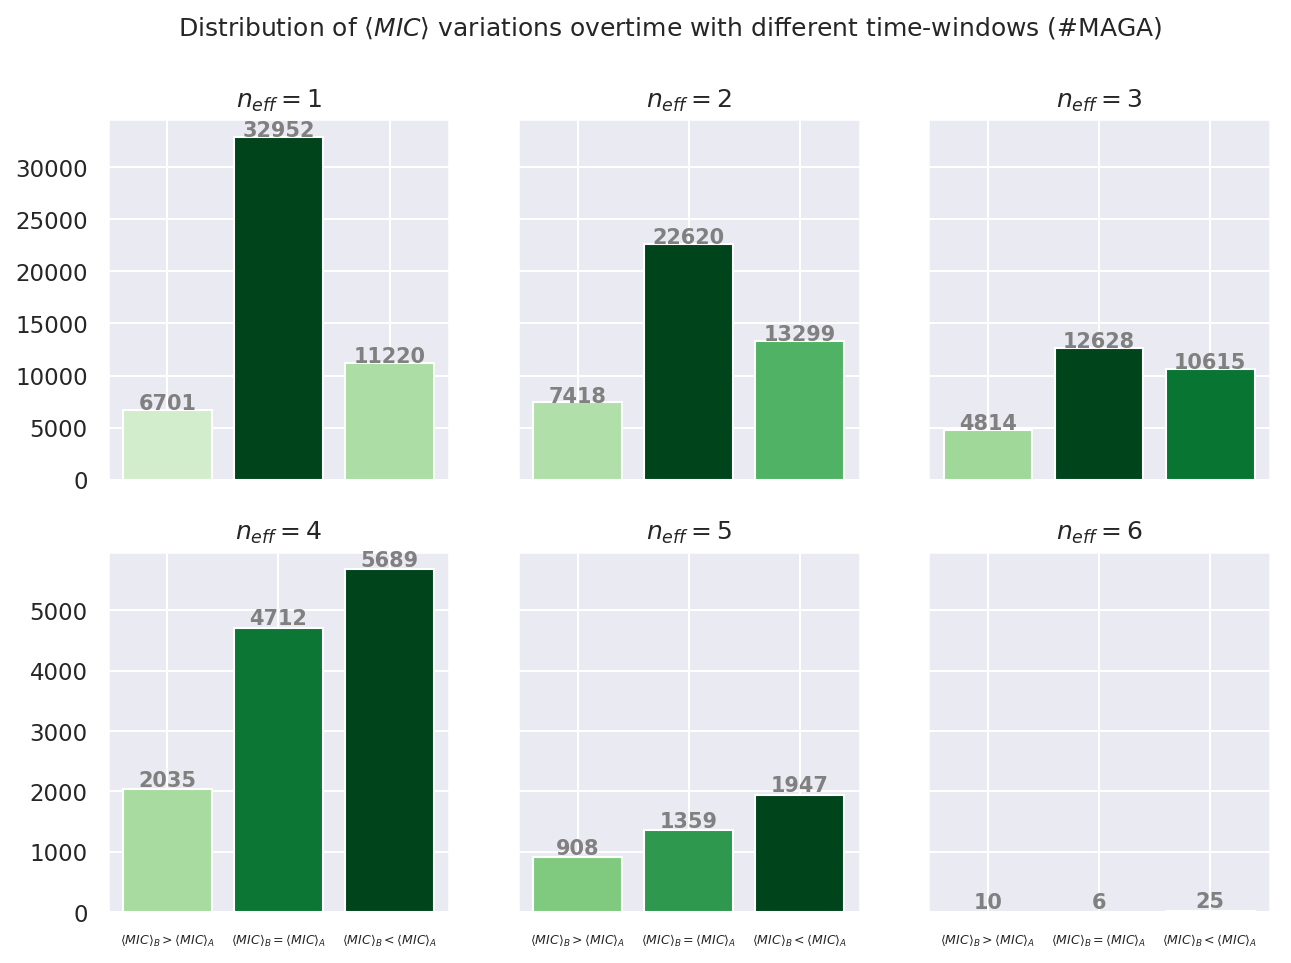

In [26]:
plot_mic_by_n_eff(n_eff_values, cm, hashtag, hashtag_full)